In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [2]:
data = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [3]:
data

,DateTime,Room_Temp(�C),T1(�C),T2(�C),T3(�C),T4(�C),T5(�C),T6(�C),T8(�C),T9(�C),...,Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),WS_Temperature(�C),WS_SolarRadiation(w/m�),WS_WindDirection_Slope(w/m�),Thermal_Operation_Mode,Total_Consumption(W),Total_Production(W)
0,2021-04-27 10:59:00,25.80,39.7642,38.9047,30.2405,29.2547,30.6289,23.8826,21.1263,43.1663,...,-9.0,5400.0,249.0,0.0,19.0,415.9,424.842,NaN,0,0
1,2021-04-27 11:00:00,25.80,40.1910,39.9168,30.2350,29.2187,30.5723,23.7865,21.1465,43.1815,...,-9.0,5655.0,274.0,0.0,19.0,415.9,437.187,NaN,0,0
2,2021-04-27 11:01:00,25.80,46.5653,40.5658,30.2460,29.1893,30.5332,23.6677,21.1420,43.1830,...,-9.0,5777.0,276.0,0.0,19.0,415.9,455.580,NaN,0,0
3,2021-04-27 11:02:00,25.80,49.1767,42.5260,30.2463,29.1720,30.5095,23.6100,21.1353,43.1763,...,-9.0,6116.0,276.0,0.0,19.0,415.9,493.072,NaN,0,0
4,2021-04-27 11:03:00,25.80,46.0035,44.3658,30.2517,29.1640,30.4855,23.5548,21.1123,43.1638,...,-9.0,5049.0,276.0,0.0,19.0,415.9,410.092,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224874,2021-11-04 16:24:00,26.70,44.6310,39.6540,30.6040,29.2290,29.8980,100.0000,19.7600,51.4850,...,183.0,959.0,29.0,374.0,17.0,13.4,82.673,0.0,635,1516
224875,2021-11-04 16:25:00,26.70,44.5840,39.5610,30.5810,29.2070,29.8790,100.0000,19.7520,51.4730,...,174.0,912.0,29.0,374.0,17.0,13.4,78.300,0.0,634,1460
224876,2021-11-04 16:26:00,26.70,44.4540,39.4660,30.5750,29.2010,29.8740,100.0000,19.7520,51.4760,...,167.0,874.0,29.0,374.0,17.0,13.4,74.750,0.0,634,1415
224877,2021-11-04 16:27:00,26.70,44.3810,39.3810,30.5520,29.1830,29.8660,100.0000,19.7520,51.4840,...,161.0,848.0,29.0,375.0,17.0,13.4,72.533,0.0,1423,1384


In [4]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Room_Temp(�C)', 'T1(�C)', 'T2(�C)', 'T3(�C)', 'T4(�C)', 'T5(�C)', 'T6(�C)', 'T8(�C)', 'T9(�C)', 'T10(�C)', 'T12(�C)', 'F1(lpm)', 'F2(lpm)', 'F3(lpm)', 'F4(lpm)', 'ESS_Power(W)', 'Pvt_Supply(W)', 'Pv_Supply(W)', 'Heatpump_Load(W)', 'FuelCell_Supply(W)', 'WS_Temperature(�C)', 'WS_SolarRadiation(w/m�)', 'WS_WindDirection_Slope(w/m�)', 'Thermal_Operation_Mode', 'Total_Consumption(W)', 'Total_Production(W)']


In [6]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['Slope_solar_radiation(w/m2)'] = data['WS_WindDirection_Slope(w/m�)']
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']

df_kepsh1.head()


,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W)
0,2021-04-27 10:59:00,5400.0,0.0,424.842,0.0,249.0,0,0
1,2021-04-27 11:00:00,5655.0,0.0,437.187,0.0,274.0,0,0
2,2021-04-27 11:01:00,5777.0,0.0,455.580,0.0,276.0,0,0
3,2021-04-27 11:02:00,6116.0,0.0,493.072,0.0,276.0,0,0
4,2021-04-27 11:03:00,5049.0,0.0,410.092,0.0,276.0,0,0


In [7]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [8]:
df_kepsh1 = df_kepsh1[df_kepsh1['Cons_kepsh1(W)']< 10000]

In [9]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-08-21 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-11-03 23:59:00') ]

In [10]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94989 entries, 128900 to 223889
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         94989 non-null  datetime64[ns]
 1   PV_kepsh1(W)                 94866 non-null  float64       
 2   PVT_kepsh1(W)                94866 non-null  float64       
 3   Slope_solar_radiation(w/m2)  94866 non-null  float64       
 4   FC(W)                        94866 non-null  float64       
 5   HP_kepsh1(W)                 94866 non-null  float64       
 6   Cons_kepsh1(W)               94989 non-null  int64         
 7   Prod_kepsh1(W)               94989 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 6.5 MB


In [11]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [12]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [13]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [14]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [15]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [16]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [17]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94989 entries, 128900 to 223889
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         94989 non-null  datetime64[ns]
 1   PV_kepsh1(W)                 94866 non-null  float64       
 2   PVT_kepsh1(W)                94866 non-null  float64       
 3   Slope_solar_radiation(w/m2)  94866 non-null  float64       
 4   FC(W)                        94866 non-null  float64       
 5   HP_kepsh1(W)                 94866 non-null  float64       
 6   Cons_kepsh1(W)               94989 non-null  float64       
 7   Prod_kepsh1(W)               94989 non-null  float64       
 8   Cons_acc_kepsh1(Wh)          94989 non-null  float64       
 9   Prod_acc_kepsh1(Wh)          94989 non-null  float64       
 10  PV_acc_kepsh1(Wh)            94866 non-null  float64       
 11  PVT_acc_kepsh1(Wh)           94866 

In [18]:
df_kepsh1.to_csv('./211108_kepsh1.csv')

In [19]:
df_kepsh1

,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),Cons_acc_kepsh1(Wh),Prod_acc_kepsh1(Wh),...,PVT_acc_kepsh1(Wh),FC_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
128900,2021-08-21 00:00:00,0.0,9.0,0.0,413.0,29.0,1002.0,1301.0,1.670000e+01,2.168333e+01,...,0.150000,6.883333,1002.0,1.670000e+01,0.770177,1.000000,0.770177,1.000000,1.298403,0.885088
128901,2021-08-21 00:01:00,0.0,8.0,0.0,413.0,29.0,1032.0,1052.0,3.390000e+01,3.921667e+01,...,0.283333,13.766667,1032.0,3.390000e+01,0.980989,1.000000,0.864428,1.000000,1.156834,0.932214
128902,2021-08-21 00:02:00,0.0,8.0,0.0,413.0,29.0,1118.0,421.0,5.253333e+01,4.623333e+01,...,0.416667,20.650000,421.0,4.623333e+01,1.000000,0.376565,1.000000,0.880076,0.880076,0.940038
128903,2021-08-21 00:03:00,0.0,9.0,0.0,414.0,29.0,1115.0,422.0,7.111667e+01,5.326667e+01,...,0.566667,27.550000,422.0,5.326667e+01,1.000000,0.378475,1.000000,0.749004,0.749004,0.874502
128904,2021-08-21 00:04:00,0.0,9.0,0.0,414.0,29.0,1113.0,423.0,8.966667e+01,6.031667e+01,...,0.716667,34.450000,423.0,6.031667e+01,1.000000,0.380054,1.000000,0.672677,0.672677,0.836338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223885,2021-11-03 23:55:00,0.0,0.0,0.0,569.0,29.0,892.0,569.0,1.991128e+06,3.412549e+06,...,87737.583333,263570.316667,569.0,1.991128e+06,1.000000,0.637892,0.583472,1.000000,1.713877,0.791736
223886,2021-11-03 23:56:00,0.0,0.0,0.0,568.0,29.0,896.0,568.0,1.991143e+06,3.412558e+06,...,87737.583333,263579.783333,568.0,1.991143e+06,1.000000,0.633929,0.583475,1.000000,1.713869,0.791738
223887,2021-11-03 23:57:00,0.0,0.0,0.0,568.0,29.0,897.0,568.0,1.991158e+06,3.412568e+06,...,87737.583333,263589.250000,568.0,1.991158e+06,1.000000,0.633222,0.583478,1.000000,1.713861,0.791739
223888,2021-11-03 23:58:00,0.0,0.0,0.0,570.0,29.0,892.0,570.0,1.991173e+06,3.412577e+06,...,87737.583333,263598.750000,570.0,1.991173e+06,1.000000,0.639013,0.583481,1.000000,1.713853,0.791740


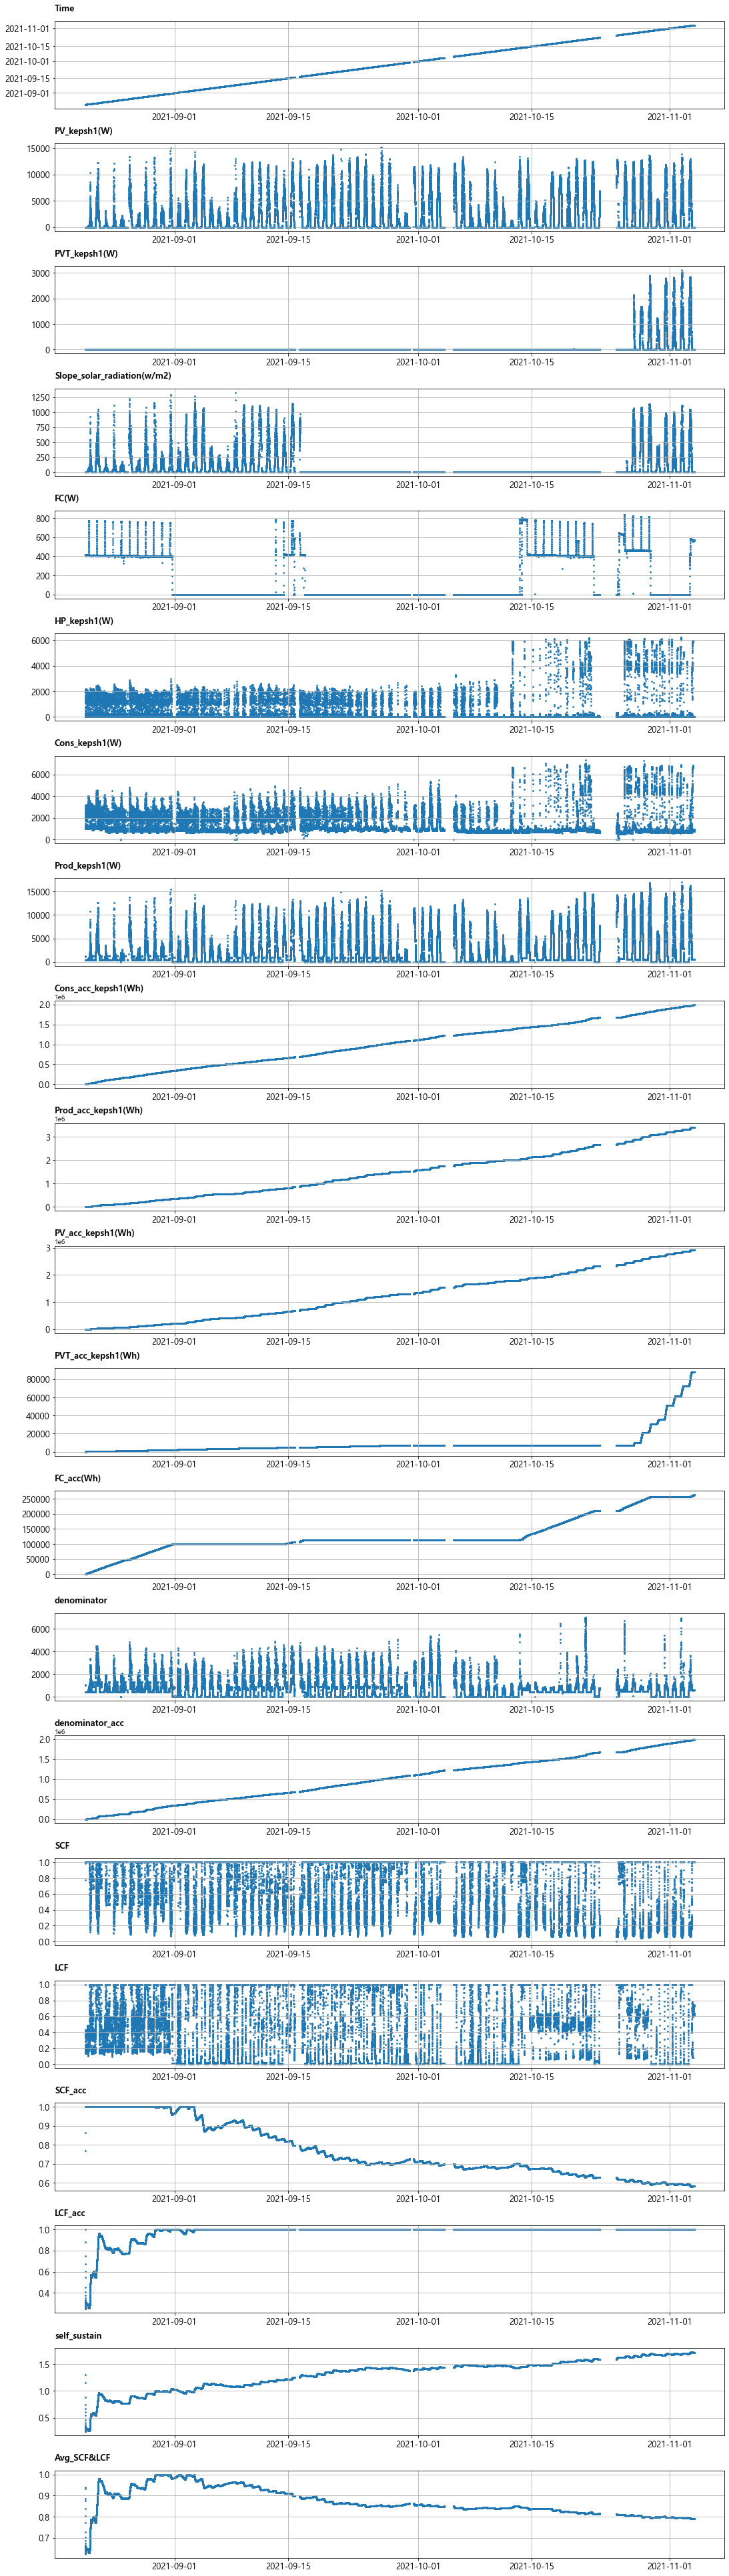

In [20]:
fig, ax = plt.subplots(figsize=(18,70))


for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kepsh1.columns[i]
    plt.scatter(x=df_kepsh1['Time'], y=df_kepsh1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line graph

In [21]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [22]:
df_kepsh1.to_csv('./211108_kepsh1.csv')

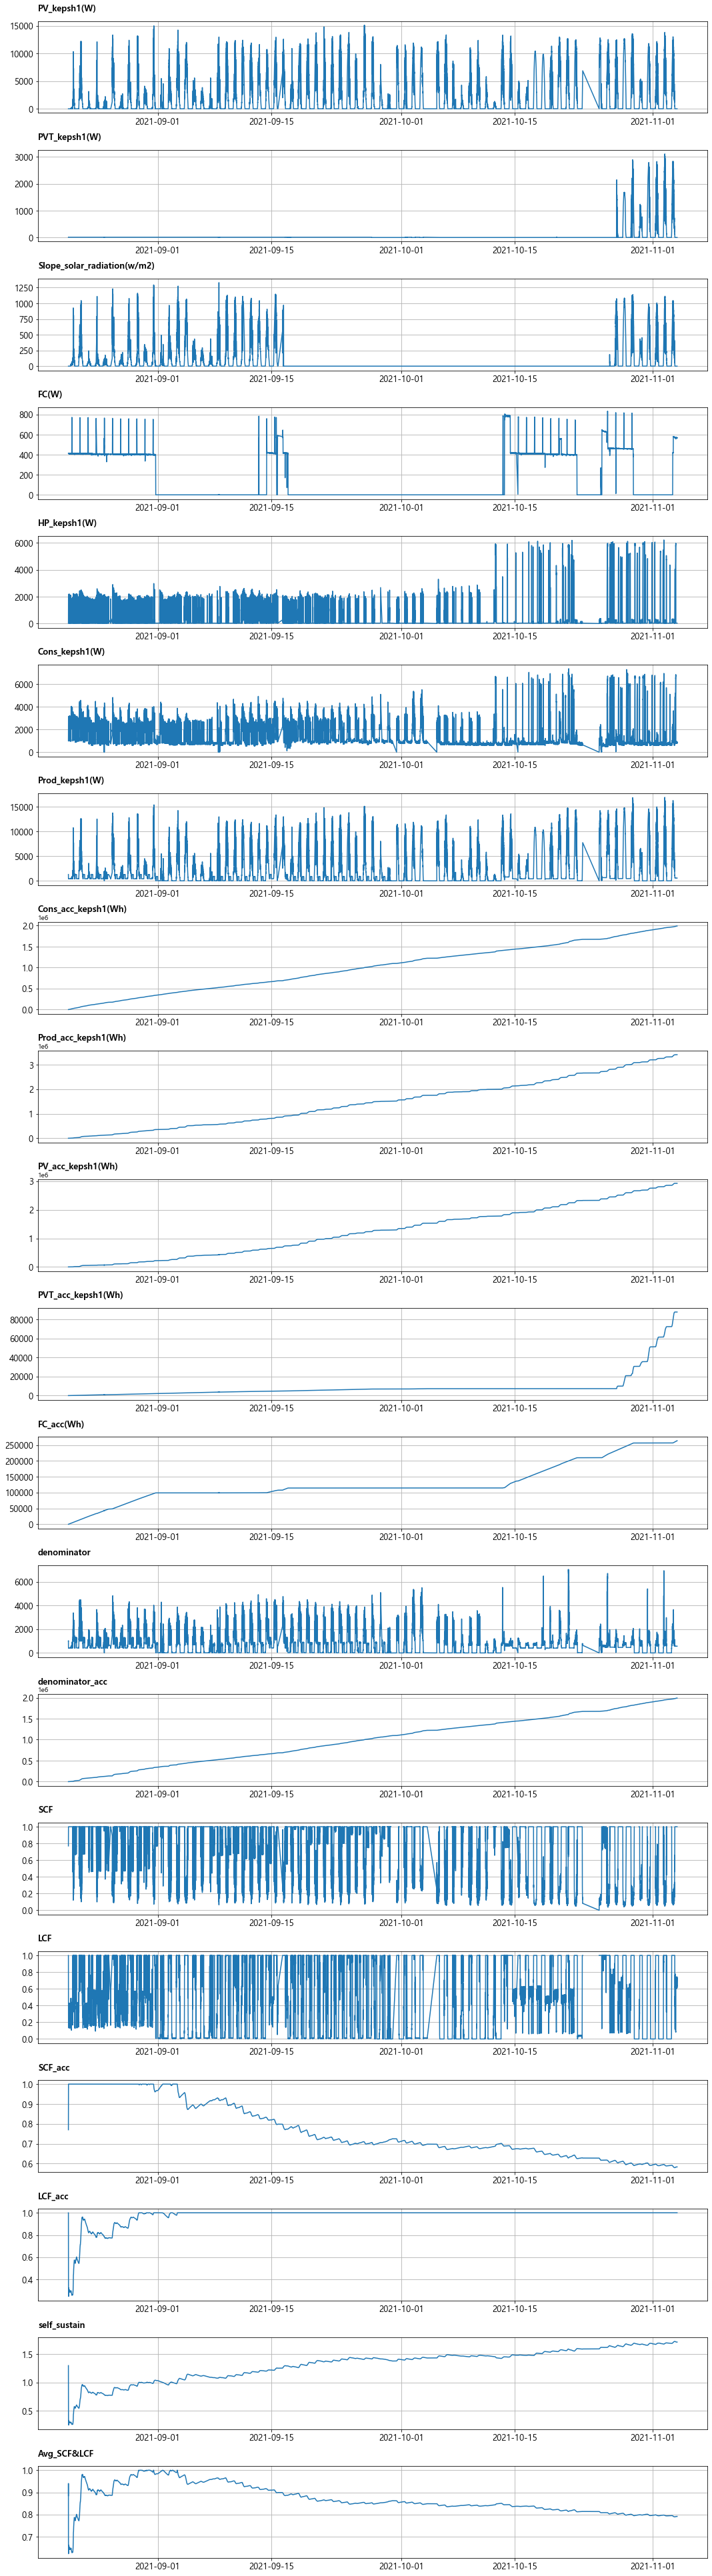

In [23]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kepsh1.columns[i]
    plt.plot(df_kepsh1[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()